# Skin Type Classification with EfficientNet-B0

Classifying skin images into 3 categories: **dry**, **normal**, and **oily**.

## 1. Import Libraries

In [ ]:
import os
from pathlib import Path

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from collections import Counter
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 2. Data Transforms

Minimal augmentation: only vertical flip for training. ImageNet normalization for pretrained model.

In [ ]:
ALL_DATA_ROOT = Path(r"./Oily-Dry-Skin-Types")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

## 3. Load and Split Data

Combine all data (train + valid + test folders) then split properly 80/10/10 for better distribution.

In [ ]:
# Load all data from train, valid, and test folders with NO transform initially
train_data = datasets.ImageFolder(root=str(ALL_DATA_ROOT / "train"))
val_data = datasets.ImageFolder(root=str(ALL_DATA_ROOT / "valid"))
test_data = datasets.ImageFolder(root=str(ALL_DATA_ROOT / "test"))

from torch.utils.data import ConcatDataset
full_dataset = ConcatDataset([train_data, val_data, test_data])

print(f"Total combined images: {len(full_dataset)}")
print(f"  - From train: {len(train_data)}")
print(f"  - From valid: {len(val_data)}")
print(f"  - From test: {len(test_data)}")

from torch.utils.data import random_split, Subset

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = int(0.1 * total_size)
val_size = total_size - train_size - test_size

generator = torch.Generator().manual_seed(42)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(full_dataset)), [train_size, val_size, test_size], generator=generator
)

print(f"\nAfter splitting:")
print(f"Train samples: {len(train_indices)}")
print(f"Val samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")

# Create custom dataset class that applies transforms
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets with proper transforms
train_dataset = TransformedSubset(full_dataset, train_indices.indices, train_transform)
val_dataset = TransformedSubset(full_dataset, val_indices.indices, val_test_transform)
test_dataset = TransformedSubset(full_dataset, test_indices.indices, val_test_transform)

Total combined images: 3152
  - From train: 2756
  - From valid: 262
  - From test: 134

After splitting:
Train samples: 2521
Val samples: 316
Test samples: 315


## 4. Check Class Distribution

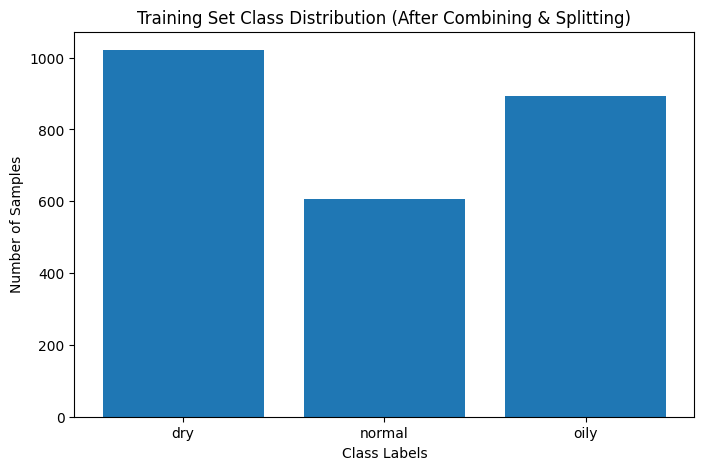

Training set label distribution:
Label 1: 1021 images
Label 0: 607 images
Label 2: 893 images


In [ ]:
# Get label distribution for training set
train_labels = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    train_labels.append(label)

train_label_counts = Counter(train_labels)

plt.figure(figsize=(8, 5))
plt.bar(["dry", "normal", "oily"], train_label_counts.values())
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Training Set Class Distribution (After Combining & Splitting)')
plt.show()

print("Training set label distribution:")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count} images")

## 5. Create Data Loaders

In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


## 6. Model Configuration

We tried a few configuration for the **EfficientNet-B0** with 5.3M parameters
- **LR**: 3e-3 (Tried 1e-3, 5e-3, 1e-4, 1e-2, and 3e-3 comes up with the best result)
- **Optimizer**: SGD with momentum (better generalization than Adam for EfficientNet)
- **Scheduler**: StepLR reduces LR by 10x at epoch 15

In [ ]:
NUM_CLASSES = 3
EPOCHS = 50
PATIENCE = 10

In [ ]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = efficientnet_b0(weights=weights)

in_features = base_model.classifier[1].in_features
base_model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model = base_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=3e-3,
    momentum=0.9,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=15,
    gamma=0.1
)

## 7. Training Functions

In [ ]:
def run_epoch(model, dataloader, criterion, device, phase="train"):
    if phase == "train":
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    if phase == "train":
        desc = "Train"
    else:
        desc = "Val"

    for images, labels in tqdm(dataloader, desc=f"{desc} - {phase}", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        if phase == "train":
            optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
            outputs = model(images)           # [B, num_classes]
            loss = criterion(outputs, labels)

            if phase == "train":
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.detach().cpu().tolist())
        all_preds.extend(preds.detach().cpu().tolist())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # compute precision, recall, f1
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_state_dict = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


## 8. Train Model

Training with early stopping based on validation loss.

In [ ]:
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.0)

history = {
    "train_loss": [],
    "train_acc": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": [],
}

try:
    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")

        # TRAIN
        train_loss, train_acc, train_prec, train_rec, train_f1 = run_epoch(
            model, train_loader, criterion, device, phase="train"
        )

        # VAL
        val_loss, val_acc, val_prec, val_rec, val_f1 = run_epoch(
            model, val_loader, criterion, device, phase="val"
        )

        # update LR scheduler (StepLR)
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_precision"].append(train_prec)
        history["train_recall"].append(train_rec)
        history["train_f1"].append(train_f1)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_prec)
        history["val_recall"].append(val_rec)
        history["val_f1"].append(val_f1)

        print(
            f"Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
            f"Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}"
        )
        print(
            f"Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | "
            f"Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}"
        )

        early_stopping(val_loss, model) # Early stop based on val loss
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch}.")
            torch.save(early_stopping.best_state_dict, "classification_model_best.pth")
            break

except KeyboardInterrupt:
    print("\nTraining is interrupted by user. Saving model at last epoch.")
    torch.save(model.state_dict(), "classification_model_last.pth")

if early_stopping.best_state_dict is not None:
    model.load_state_dict(early_stopping.best_state_dict)
    model = model.to(device)


Epoch 1/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 1.0708 | Acc: 0.4217 | Prec: 0.3852 | Rec: 0.3791 | F1: 0.3639
Val   - Loss: 1.0563 | Acc: 0.4557 | Prec: 0.4533 | Rec: 0.4216 | F1: 0.4113

Epoch 2/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.9933 | Acc: 0.5133 | Prec: 0.5067 | Rec: 0.4651 | F1: 0.4519
Val   - Loss: 1.0164 | Acc: 0.4810 | Prec: 0.4712 | Rec: 0.4522 | F1: 0.4495

Epoch 3/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.9152 | Acc: 0.5799 | Prec: 0.5766 | Rec: 0.5431 | F1: 0.5437
Val   - Loss: 0.9658 | Acc: 0.5222 | Prec: 0.5317 | Rec: 0.4874 | F1: 0.4843

Epoch 4/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.8527 | Acc: 0.6303 | Prec: 0.6251 | Rec: 0.5925 | F1: 0.5942
Val   - Loss: 0.9137 | Acc: 0.5728 | Prec: 0.5921 | Rec: 0.5368 | F1: 0.5363

Epoch 5/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.7723 | Acc: 0.6803 | Prec: 0.6774 | Rec: 0.6512 | F1: 0.6567
Val   - Loss: 0.9109 | Acc: 0.5918 | Prec: 0.6199 | Rec: 0.5605 | F1: 0.5665

Epoch 6/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.6773 | Acc: 0.7303 | Prec: 0.7322 | Rec: 0.7006 | F1: 0.7076
Val   - Loss: 0.8288 | Acc: 0.6266 | Prec: 0.6234 | Rec: 0.5916 | F1: 0.5927

Epoch 7/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.5830 | Acc: 0.7886 | Prec: 0.7898 | Rec: 0.7666 | F1: 0.7739
Val   - Loss: 0.8256 | Acc: 0.6297 | Prec: 0.6297 | Rec: 0.6031 | F1: 0.6073

Epoch 8/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.5120 | Acc: 0.8092 | Prec: 0.8052 | Rec: 0.7921 | F1: 0.7971
Val   - Loss: 0.7569 | Acc: 0.6899 | Prec: 0.6978 | Rec: 0.6536 | F1: 0.6574

Epoch 9/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.4156 | Acc: 0.8524 | Prec: 0.8489 | Rec: 0.8392 | F1: 0.8432
Val   - Loss: 0.6978 | Acc: 0.7152 | Prec: 0.7113 | Rec: 0.6986 | F1: 0.7031

Epoch 10/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.3442 | Acc: 0.8846 | Prec: 0.8807 | Rec: 0.8766 | F1: 0.8785
Val   - Loss: 0.7206 | Acc: 0.7057 | Prec: 0.7069 | Rec: 0.6824 | F1: 0.6885

Epoch 11/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.3142 | Acc: 0.8973 | Prec: 0.8994 | Rec: 0.8873 | F1: 0.8924
Val   - Loss: 0.6810 | Acc: 0.7310 | Prec: 0.7260 | Rec: 0.7248 | F1: 0.7241

Epoch 12/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.2314 | Acc: 0.9278 | Prec: 0.9255 | Rec: 0.9228 | F1: 0.9241
Val   - Loss: 0.7109 | Acc: 0.7468 | Prec: 0.7696 | Rec: 0.7190 | F1: 0.7291

Epoch 13/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.2015 | Acc: 0.9405 | Prec: 0.9386 | Rec: 0.9354 | F1: 0.9369
Val   - Loss: 0.6631 | Acc: 0.7500 | Prec: 0.7506 | Rec: 0.7300 | F1: 0.7362

Epoch 14/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1665 | Acc: 0.9484 | Prec: 0.9480 | Rec: 0.9440 | F1: 0.9459
Val   - Loss: 0.6386 | Acc: 0.7816 | Prec: 0.7767 | Rec: 0.7691 | F1: 0.7722

Epoch 15/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1499 | Acc: 0.9536 | Prec: 0.9530 | Rec: 0.9502 | F1: 0.9515
Val   - Loss: 0.6324 | Acc: 0.8070 | Prec: 0.8259 | Rec: 0.7934 | F1: 0.8031

Epoch 16/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1209 | Acc: 0.9663 | Prec: 0.9652 | Rec: 0.9661 | F1: 0.9656
Val   - Loss: 0.6137 | Acc: 0.7943 | Prec: 0.8063 | Rec: 0.7807 | F1: 0.7885

Epoch 17/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1220 | Acc: 0.9651 | Prec: 0.9649 | Rec: 0.9630 | F1: 0.9639
Val   - Loss: 0.6086 | Acc: 0.7880 | Prec: 0.7881 | Rec: 0.7773 | F1: 0.7812

Epoch 18/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1169 | Acc: 0.9651 | Prec: 0.9640 | Rec: 0.9643 | F1: 0.9641
Val   - Loss: 0.6092 | Acc: 0.7975 | Prec: 0.8061 | Rec: 0.7838 | F1: 0.7910

Epoch 19/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1122 | Acc: 0.9699 | Prec: 0.9698 | Rec: 0.9674 | F1: 0.9686
Val   - Loss: 0.6074 | Acc: 0.7943 | Prec: 0.8020 | Rec: 0.7811 | F1: 0.7881

Epoch 20/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1091 | Acc: 0.9706 | Prec: 0.9696 | Rec: 0.9695 | F1: 0.9696
Val   - Loss: 0.5993 | Acc: 0.7848 | Prec: 0.7865 | Rec: 0.7733 | F1: 0.7783

Epoch 21/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1068 | Acc: 0.9687 | Prec: 0.9676 | Rec: 0.9660 | F1: 0.9668
Val   - Loss: 0.6090 | Acc: 0.7943 | Prec: 0.8045 | Rec: 0.7811 | F1: 0.7888

Epoch 22/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0992 | Acc: 0.9758 | Prec: 0.9745 | Rec: 0.9758 | F1: 0.9751
Val   - Loss: 0.6219 | Acc: 0.7911 | Prec: 0.8004 | Rec: 0.7785 | F1: 0.7861

Epoch 23/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.1037 | Acc: 0.9699 | Prec: 0.9693 | Rec: 0.9682 | F1: 0.9687
Val   - Loss: 0.6237 | Acc: 0.7943 | Prec: 0.7982 | Rec: 0.7786 | F1: 0.7854

Epoch 24/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0961 | Acc: 0.9754 | Prec: 0.9761 | Rec: 0.9726 | F1: 0.9743
Val   - Loss: 0.6151 | Acc: 0.7911 | Prec: 0.7941 | Rec: 0.7787 | F1: 0.7843

Epoch 25/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0999 | Acc: 0.9770 | Prec: 0.9762 | Rec: 0.9770 | F1: 0.9766
Val   - Loss: 0.6165 | Acc: 0.7975 | Prec: 0.8051 | Rec: 0.7841 | F1: 0.7914

Epoch 26/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0876 | Acc: 0.9790 | Prec: 0.9782 | Rec: 0.9792 | F1: 0.9787
Val   - Loss: 0.6132 | Acc: 0.7975 | Prec: 0.7993 | Rec: 0.7846 | F1: 0.7901

Epoch 27/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0919 | Acc: 0.9778 | Prec: 0.9774 | Rec: 0.9773 | F1: 0.9774
Val   - Loss: 0.6224 | Acc: 0.8006 | Prec: 0.8155 | Rec: 0.7854 | F1: 0.7951

Epoch 28/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0973 | Acc: 0.9738 | Prec: 0.9736 | Rec: 0.9725 | F1: 0.9730
Val   - Loss: 0.6131 | Acc: 0.7880 | Prec: 0.7964 | Rec: 0.7756 | F1: 0.7828

Epoch 29/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0944 | Acc: 0.9710 | Prec: 0.9711 | Rec: 0.9686 | F1: 0.9698
Val   - Loss: 0.6100 | Acc: 0.7943 | Prec: 0.7994 | Rec: 0.7814 | F1: 0.7878

Epoch 30/50


Train - train:   0%|          | 0/40 [00:00<?, ?it/s]

Val - val:   0%|          | 0/5 [00:00<?, ?it/s]

Train - Loss: 0.0910 | Acc: 0.9746 | Prec: 0.9739 | Rec: 0.9740 | F1: 0.9739
Val   - Loss: 0.6135 | Acc: 0.7880 | Prec: 0.8003 | Rec: 0.7737 | F1: 0.7818

Early stopping triggered at epoch 30.


## 9. Save Model

In [ ]:
torch.save(model.state_dict(), "classification_model_last.pth")

## 10. Plot Train / Val Loss

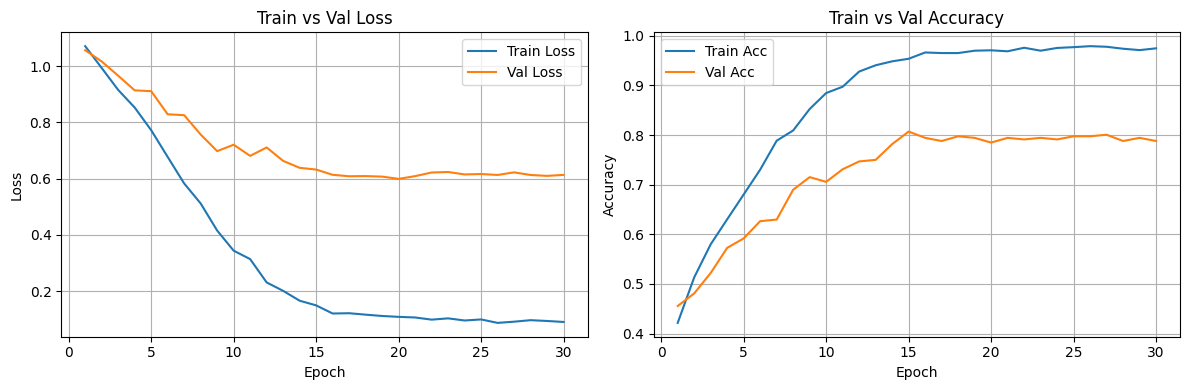

In [ ]:
import matplotlib.pyplot as plt

epochs_ran = len(history["train_loss"])
epochs_range = range(1, epochs_ran + 1)

plt.figure(figsize=(12, 4))

# Acc
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report

def get_all_preds_and_labels(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

train_labels_all, train_preds_all = get_all_preds_and_labels(model, train_loader, device)
train_f1 = f1_score(train_labels_all, train_preds_all, average="macro", zero_division=0)

val_labels_all, val_preds_all = get_all_preds_and_labels(model, val_loader, device)
val_f1 = f1_score(val_labels_all, val_preds_all, average="macro", zero_division=0)
print(f"Final Train F1-score: {train_f1:.4f}")
print(f"Final Val   F1-score: {val_f1:.4f}")

Final Train F1-score: 0.9930
Final Val   F1-score: 0.7783


## 11. Model Inference to Test Set

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test samples: {len(test_dataset)}")

Test samples: 315


In [ ]:
test_labels_all, test_preds_all = get_all_preds_and_labels(model, test_loader, device)
test_f1 = f1_score(test_labels_all, test_preds_all, average="macro", zero_division=0)

print(f"Final Test F1-score: {test_f1:.4f}")
print("\n=== Classification Report (Test) ===")
print(classification_report(test_labels_all, test_preds_all, digits=4))

Final Test F1-score: 0.8501

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.8382    0.7703    0.8028        74
           1     0.8507    0.8769    0.8636       130
           2     0.8761    0.8919    0.8839       111

    accuracy                         0.8571       315
   macro avg     0.8550    0.8464    0.8501       315
weighted avg     0.8567    0.8571    0.8565       315



## 12. Confusion Matrix

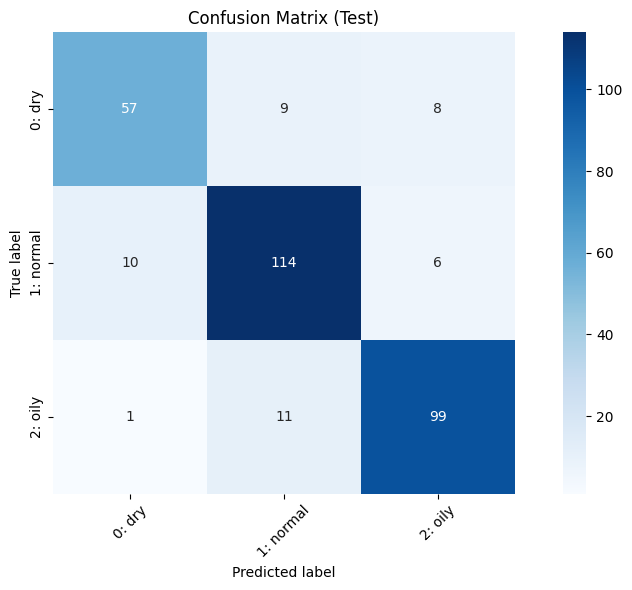

In [ ]:
cm = confusion_matrix(test_labels_all, test_preds_all)

classes = ["0: dry", "1: normal", "2: oily"]

plt.figure(figsize=(10, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

The EfficientNet-B0 model achieved 0.8571 test accuracy with a macro F1-score of 0.8501. Training loss decreased steadily, while validation loss also decreased and converged around 0.61, indicating stable learning without severe overfitting.

The confusion matrix reveals that the oily class performs best, with the highest number of correct predictions and minimal confusion with other categories. In contrast, the dry class shows more misclassifications, most often confused with the normal class. This pattern suggests overlapping visual characteristics between dry and normal skin textures.

These results indicate that the model could benefit from additional training samples for the dry class, as well as targeted data augmentation or texture-focused feature extraction to better distinguish subtle differences between dry and normal skin conditions.